# LinkedIn Profile Extractor - Marco Villanueva Legler - 20020571

This scraping script uses the Selenium library to extract LinkedIn profile data from:
1. **LinkedIn event** or **Search link**
2. **LinkedIn Post**
3. **Previously scraped LinkedIn profile data (csv file)**

The script extracts the following data points for each scraped profile:
- First Name
- Last Name
- Full Name
- Profile Link
- Degree of Connection
- Bio
- Location
- Reaction Type (if from a post)
- Country
- Job Title
- Employment Duration
- Employment Span
- Professionally active (active/inactive)
- Company Name
- Company Size
- Company Link
- Education Degree
- University Attended
- Phone Number
- Email Address
- Twitter Handle
- Birthday

### Data Utilization:

1. **Marketing and Networking Purposes:**
   - Targeted Advertising: By knowing specific attributes of individuals, such as their sector, interests, or location, marketing campaigns can be more accurately tailored, reducing ad costs.
   - Audience Analysis: Analyzing profiles helps in understanding the characteristics of people in specific sectors or with similar interests.
   - Network Expansion: By identifying individuals with similar interests or backgrounds, it's easier to extend your personal network, increasing the chance of having your connection requests accepted.

2. **Machine Learning/Deep Learning Projects:**
   - Predictive Analytics: Use attributes like job title, company, and education to predict career progression trends or industry shifts.
   - Recommendation Systems: Develop systems that recommend articles, connections, or jobs based on user profiles and behavior.
   - Network Analysis: Employ algorithms to analyze social networks and understand relationship dynamics within specific industries or regions.

### Example of extracted data:
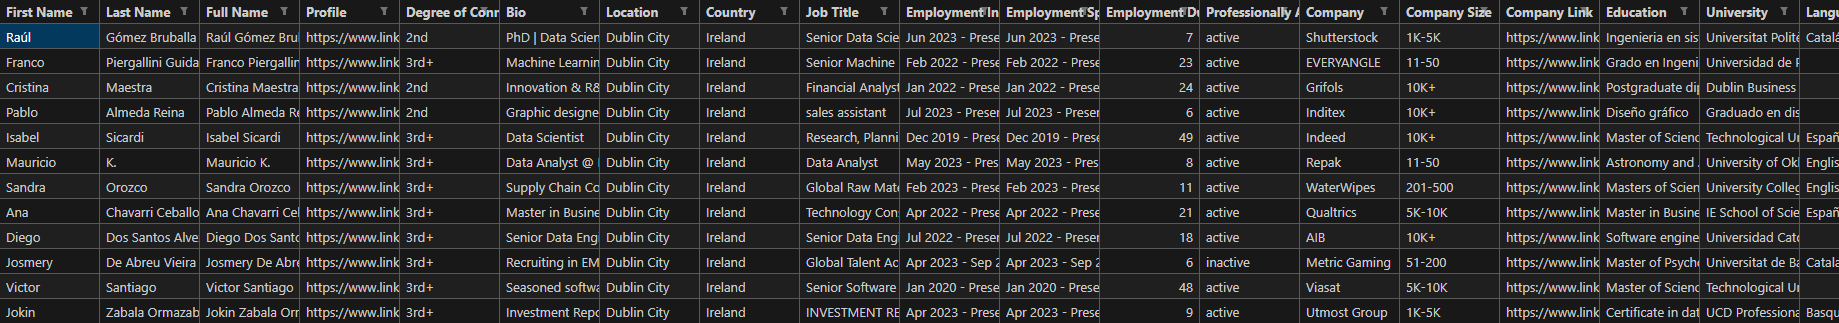

# Motivation
My motivation for creating the LinkedIn Profile Extractor stems from recognizing the immense value hidden within LinkedIn profiles. By deeply understanding individuals, we can connect more effectively and efficiently. This tool allows for precise filtering and connection with the right people, especially when enhanced with a language model to craft personalized connection requests based on mutual interests and goals. Furthermore, the tool facilitates large-scale analysis of specific groups, leveraging LinkedIn's search filters. It also targets active users, like those engaging with posts, ensuring that we reach people genuinely interested and active in relevant topics. This is especially powerful for job searches; in today's competitive market, direct messaging through LinkedIn can be a game-changer. This tool simplifies finding potential contacts open to discussions, giving a significant edge in exploring career opportunities.

# 1. Preparation

## Imports required libraries and modules
Keep in mind to pass your login information to `LOGIN_EMAIL` and `LOGIN_PASSWORD`.

## Install these packages

In [ ]:
# Use !% to run shell commands from Jupyter Notebook
!%pip install requests pandas tqdm selenium

In [1]:
import time
import re
import random
import pandas as pd
import math
import os
import csv
from tqdm import tqdm
from datetime import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException, StaleElementReferenceException, WebDriverException, TimeoutException

## Inputs

To use this script, you need to:

- **Login Credentials**: Set your LinkedIn login email and password in the `LOGIN_EMAIL` and `LOGIN_PASSWORD` variables.

- **Chromedriver**: Download Chromedriver from [here](https://googlechromelabs.github.io/chrome-for-testing/) and specify its local path in the `CHROMEDRIVER_PATH` variable.

Ensure these configurations are set before running the script.


In [25]:
LOGIN_EMAIL = "INPUT_YOUR_EMAIL_HERE"
LOGIN_PASSWORD = "INPUT_YOUR_PASSWORD_HERE"
CHROMEDRIVER_PATH = "C:/Program Files/chromedriver.exe" # Change the path to the chrome driver if needed
MIN_DELAY, MAX_DELAY = 5, 15 # Minimal and maximal action step delay between two profiles

In [26]:
service = Service(CHROMEDRIVER_PATH)
chrome_options = Options()
driver = None # Set to empty value to impede browser window

## Run the driver and the helper functions

In [4]:
def human_write(field, text):
    for char in text:
        # Check if the character is in the BMP range
        if ord(char) <= 0xFFFF:
            field.send_keys(char)
        else:
            print(f"Skipping non-BMP character: {char}")

def split_name(full_name):
    parts = full_name.split()
    first_name = parts[0]
    last_name = ' '.join(parts[1:])
    return first_name, last_name.strip()

def loc_parser(loc_str:str):
    loc_list = loc_str.strip().split(", ")
    return loc_list[-1]

def sleep_time(min_seconds, max_seconds):
    time.sleep(random.uniform(min_seconds, max_seconds))

def login(email:str, password:str):
    driver.get("https://www.linkedin.com/")
    email_field = driver.find_element(By.ID, 'session_key')
    human_write(email_field, email)
    time.sleep(1)
    password_field = driver.find_element(By.ID, 'session_password')
    human_write(password_field, password)
    time.sleep(1)
    driver.find_element(By.XPATH, '//*[@id="main-content"]/section[1]/div/div/form/div[2]/button').click()

def save_to_csv(dataframe: pd.DataFrame, folder_name: str, method: str, num_profiles: int):
    # Define the folder name and check if it exists
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    file_name = f'{method}_{datetime.now().strftime("%d-%m-%y_%H-%M")}_{num_profiles}.csv'
    csv_file_path = os.path.join(folder_name, file_name)

    # Save the DataFrame to CSV
    dataframe.to_csv(csv_file_path, index=False)

    print(f"CSV file saved at {csv_file_path}")

# Opening a browser window and login into LinkedIn with account information

In [27]:
driver = webdriver.Chrome(service=service, options=chrome_options)
driver.maximize_window()
login(LOGIN_EMAIL, LOGIN_PASSWORD)

# **2. Shallow scrape:** extract basic profile data for deep scrape (3 different ways)

## 1. Option: Extracting profiles from **LinkedIn event** or **Search link**
This is the first "shallow scrape" method in which the script extracts basic data of profiles from a **LinkedIn event** or **Search link**. It is a quick scrape.

You have to insert your LinkedIn search link into `SEARCH_LINK`

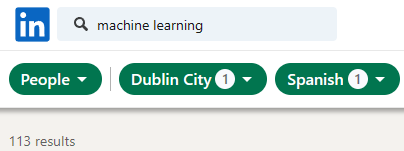

In [8]:
# This is a LinkedIn search link "machine learning" with the following filters: Dublin, Ireland | Profile language: Spanish
SEARCH_LINK = "https://www.linkedin.com/search/results/people/?geoUrn=%5B%22100354076%22%5D&keywords=machine%20learning&origin=FACETED_SEARCH&profileLanguage=%5B%22es%22%5D&sid=ZrS"

Here is the main function to extract the profile data from a LinkedIn event or a Search link:

In [9]:
def extract_search_page(driver):
    profiles = driver.find_elements(By.CSS_SELECTOR, "li.reusable-search__result-container")
    page_data = []

    for profile in profiles:
        try:
            full_name = profile.find_element(By.CSS_SELECTOR, "span.entity-result__title-text").text.strip().split('\n')[0]
            degree_of_connection_element = profile.find_elements(By.CSS_SELECTOR, "span.entity-result__badge-text")
            if not degree_of_connection_element:
                continue
            degree_of_connection = degree_of_connection_element[0].text.strip().split('\n')[1].split(' ')[0]
            bio = profile.find_element(By.CSS_SELECTOR, "div.entity-result__primary-subtitle").text.strip()
            location = profile.find_element(By.CSS_SELECTOR, "div.entity-result__secondary-subtitle").text.strip()
            profile_link_element = profile.find_element(By.CSS_SELECTOR, "a.app-aware-link")
            profile_link = profile_link_element.get_attribute('href').split('?')[0] + "/"

            if not profile_link or degree_of_connection == "Self":
                continue

            try:
                first_name, last_name = split_name(full_name)
            except IndexError:
                first_name = full_name
                last_name = ""

            # Append the data to page_data
            page_data.append({
                "First Name": first_name,
                "Last Name": last_name,
                "Full Name": full_name,
                "Profile": profile_link,
                "Degree of Connection": degree_of_connection,
                "Bio": bio,
                "Location": location
            })
        except NoSuchElementException:
            continue
    
    return page_data

### Run the profiles extraction from LinkedIn Event/Search Link

To scrape profiles from a LinkedIn event or search link:

1. **Open Webpage**: Use `driver.get(SEARCH_LINK)` to open the desired LinkedIn page.
2. **Determine Number of Pages**: Calculate the total number of pages based on search results (limit to 1000 profiles).
3. **Extract Data**: Loop through each page and use `extract_search_page(driver)` to gather profile data.
4. **Navigate Pages**: Use JavaScript for smooth scrolling and click the "Next" button to proceed through pages.
5. **Handle Pagination**: Continue until all pages are processed or the "Next" button is unavailable.
6. **Save and Display**: Store extracted data in a DataFrame, save to CSV, and display the first few entries.

A progress bar using `tqdm` shows the scraping progress, and a random sleep interval is included to reduce the likelihood of being banned.


In [10]:
driver.get(SEARCH_LINK)

# Get the number of pages to go through
results_text = driver.find_element(By.CSS_SELECTOR, "div.search-results-container h2 div").text
results_number = min(int(re.search(r'(\d+)', results_text).group(1)), 1000)  # Limit to 1000 results
pages_number = math.ceil(results_number / 10)

# Initialize a list to store all extracted data
shallow_data = []

# Loop through pages and extract data using tqdm for progress bar
with tqdm(total=pages_number, desc="Processing pages") as pbar:
    for _ in range(pages_number):
        driver.implicitly_wait(3)
        page_data = extract_search_page(driver)
        shallow_data.extend(page_data)
        
        # JavaScript to scroll smoothly to the bottom of the page
        scroll_script = "window.scrollTo({top: document.body.scrollHeight, left: 0, behavior: 'smooth'});"
        driver.execute_script(scroll_script)

        # Update the progress bar
        pbar.update(1)

        # Try to find and click the "Next" button, break the loop if not found
        try:
            next_button = driver.find_element(By.CSS_SELECTOR, "button[aria-label='Next']")
            time.sleep(3)
            if next_button.is_enabled():
                next_button.click()
                time.sleep(3)  # Wait for the next page to load
            else:
                break
        except (NoSuchElementException, ElementClickInterceptedException):
            break
        
        # Add a random sleep interval to reduce banning probability
        sleep_time(3, 7)

num_search_profiles = len(shallow_data)
search_df = pd.DataFrame(shallow_data)
save_to_csv(search_df, "shallow_data", "search", num_search_profiles)

print(f"{num_search_profiles}/{results_number} profiles correctly extracted!")
if results_number == 1000:
    print("Maximum 1000 profiles due to LinkedIn search limit")

display(search_df.head())

Processing pages: 100%|██████████| 12/12 [02:56<00:00, 14.72s/it]

CSV file saved at shallow_data\search_05-12-23_10-59_108.csv
108/116 profiles correctly extracted!


,First Name,Last Name,Full Name,Profile,Degree of Connection,Bio,Location
0,Raúl,Gómez Bruballa,Raúl Gómez Bruballa,https://www.linkedin.com/in/raulgomezbruballa/,2nd,PhD | Data Scientist at Shutterstock (Generati...,Dublin City
1,Franco,Piergallini Guida,Franco Piergallini Guida,https://www.linkedin.com/in/franco-piergallini...,3rd+,Machine Learning Engineer,Dublin City
2,Cristina,Maestra,Cristina Maestra,https://www.linkedin.com/in/cristina-maestra-2...,2nd,Innovation & R&D Controller at Grifols,Dublin City
3,Pablo,Almeda Reina,Pablo Almeda Reina,https://www.linkedin.com/in/pablo-almeda-reina...,2nd,Graphic designer,Dublin City
4,Isabel,Sicardi,Isabel Sicardi,https://www.linkedin.com/in/isabelsicardi/,3rd+,Data Scientist,Dublin City


## 2. Option: Extracting profiles who liked a **LinkedIn post**

You have to insert your LinkedIn search link into `POST_LINK`

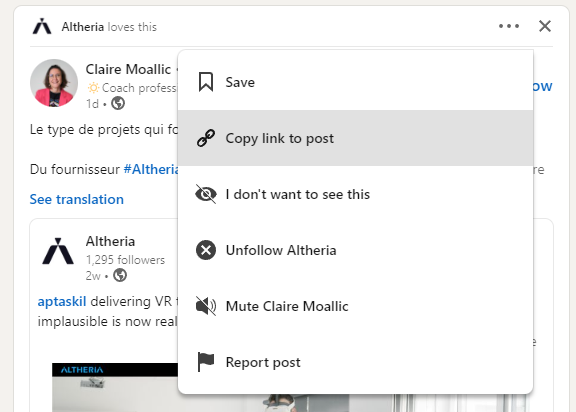

In [11]:
POST_LINK = "https://www.linkedin.com/posts/claire-moallic-165658a_immersivetraining-edtech-aptaskil-activity-7136294360286924800-j0ok?utm_source=share&utm_medium=member_desktop"

Here is the main function to extract the profile data from the reaction list of the post:

In [12]:
def extract_likers_data(reactions_list):
    likers_list = []

    for profile in tqdm(reactions_list, desc="Extracting Likers Data"):
        try:
            profile_link = profile.find_element(By.CSS_SELECTOR, "a").get_attribute('href')
        except NoSuchElementException:
            profile_link = ""

        try:
            reaction_type = profile.find_element(By.CSS_SELECTOR, "img.reactions-icon").get_attribute('alt')
        except NoSuchElementException:
            reaction_type = ""

        try:
            full_name = profile.find_element(By.CSS_SELECTOR, "div.artdeco-entity-lockup__title").text.strip().split("\n")[0]
        except NoSuchElementException:
            full_name = ""

        try:
            degree_of_connection = profile.find_element(By.CSS_SELECTOR, "div.artdeco-entity-lockup__badge").text.strip()
            degree_of_connection_parts = degree_of_connection.split("·")
            if len(degree_of_connection_parts) > 1:
                degree_of_connection = degree_of_connection_parts[1].strip()
            else:
                degree_of_connection = degree_of_connection_parts[0].strip()
        except NoSuchElementException:
            degree_of_connection = ""

        try:
            bio = profile.find_element(By.CSS_SELECTOR, "div.artdeco-entity-lockup__caption").text.strip()
        except NoSuchElementException:
            bio = ""
        
        # Skipping profiles without link and company profiles
        if not profile_link or "https://www.linkedin.com/company/" in profile_link:
            continue

        try:
            first_name, last_name = split_name(full_name)
        except IndexError:
            first_name = full_name
            last_name = ""

        profile_data = {
                "First Name": first_name,
                "Last Name": last_name,
                "Full Name": full_name,
                "Profile": profile_link,
                "Degree of Connection": degree_of_connection,
                "Bio": bio,
                "Reaction Type": reaction_type
            }

        likers_list.append(profile_data)

    return likers_list

def get_num_likers(driver):
    likers_text = driver.find_element(By.CLASS_NAME, "social-details-reactors-tab__icon-container").text
    split_text = likers_text.split("\n")

    # Check if the list has more than one element and get the second element if so
    if len(split_text) > 1:
        return split_text[1].replace(",", "")
    # If the list only has one element, return that element
    elif len(split_text) == 1:
        return split_text[0].replace(",", "")
    else:
        return "0"

### Run the profiles extraction from LinkedIn Post

To extract profiles from a LinkedIn post reaction list:

1. **Go to the Post**: Open the LinkedIn post link with the script.
2. **Scroll Reactions**: Scroll through the reactions to trigger JavaScript updates to the HTML.
3. **Profile Extraction**: After the page updates (new profiles load), the script can extract the profiles.


In [13]:
driver.get(POST_LINK)
driver.implicitly_wait(3)

try:
    # Find and click the 'reactions' button
    reactions_button = WebDriverWait(driver, 2).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "li.social-details-social-counts__reactions button"))
    )
    driver.execute_script("arguments[0].click();", reactions_button)
except Exception:
    print("Profile reaction list not found!")

# Scrolling through the profiles
try:
    while True:
        show_more_button = WebDriverWait(driver, 1).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "button.scaffold-finite-scroll__load-button"))
        )
        driver.execute_script("arguments[0].scrollIntoView(true);", show_more_button)
        try:
            show_more_button.click()
        except Exception:
            pass
        # Wait for a moment to allow new content to load
        time.sleep(1)

except Exception:
    print("Done with scrolling likers list")

Done with scrolling likers list


**Scraping the profiles:** In this cell, we finally scrape all the profile data and store it into a csv file

In [14]:
reactions_list = driver.find_elements(By.CSS_SELECTOR, "div.scaffold-finite-scroll__content ul li")
# Initialize a list to store all extracted data
shallow_data = extract_likers_data(reactions_list)

num_likers = get_num_likers(driver)
num_search_profiles = len(shallow_data)
post_df = pd.DataFrame(shallow_data)
save_to_csv(post_df, "shallow_data", "post", num_search_profiles)

print(f"{num_search_profiles}/{num_likers} profiles correctly extracted!")

display(post_df.head())

Extracting Likers Data:   0%|          | 0/13 [00:00<?, ?it/s]

Extracting Likers Data: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


CSV file saved at shallow_data\post_05-12-23_11-04_12.csv
12/13 profiles correctly extracted!


,First Name,Last Name,Full Name,Profile,Degree of Connection,Bio,Reaction Type
0,Can-David,Koycu,Can-David Koycu,https://www.linkedin.com/in/ACoAACMY-Y8BjUB6xt...,1st,Co-founder & Chief Design Officer at Altheria,love
1,Miloud,"G. NICHANE (Ph.D., PM)","Miloud G. NICHANE (Ph.D., PM)",https://www.linkedin.com/in/ACoAAA4pFpEB_RDgwJ...,2nd,"Senior MSAT, Quality, Validation & Regulatory ...",support
2,Kamshat,Saginbekova,Kamshat Saginbekova,https://www.linkedin.com/in/ACoAACjwkbwBHRwfB5...,3rd+,"PhD, Trade Control | Export Control Compliance...",like
3,Merivan,K.,Merivan K.,https://www.linkedin.com/in/ACoAABseRHgBVGf46C...,2nd,Digital Marketer,like
4,Yanis,Fares,Yanis Fares,https://www.linkedin.com/in/ACoAACGm4KUBA7kQra...,2nd,Portfolio Success Manager @ BeAngels • Sponsor...,like


## 3. Option: Importing Data from a Previous Scrape (CSV File)

To use data from a previous scrape:

1. **Set CSV Path**: Input the path of your previously scraped CSV file into `PREVIOUS_CSV_PATH`.

2. **Read and Convert Data**: 
   - Read the CSV file into a pandas DataFrame.
   - Convert the DataFrame into a list of Python dictionaries for easier manipulation during the scraping process.

In [15]:
# Input the "PREVIOUS_CSV_PATH" to the scraped data of your choice
PREVIOUS_CSV_PATH = r"INPUT_PATH_HERE"

### 3.a: Previous scraped data from this script (Shallow scrape options 1 or 2)

In [16]:
shallow_data_df = pd.read_csv(PREVIOUS_CSV_PATH)
display(shallow_data_df.head())

# Pass the dataframe to a list of dictionaries
shallow_data = shallow_data_df.to_dict(orient='records')

,First Name,Last Name,Full Name,Profile,Degree of Connection,Bio,Location
0,Raúl,Gómez Bruballa,Raúl Gómez Bruballa,https://www.linkedin.com/in/raulgomezbruballa/,2nd,PhD | Data Scientist at Shutterstock (Generati...,Dublin City
1,Franco,Piergallini Guida,Franco Piergallini Guida,https://www.linkedin.com/in/franco-piergallini...,3rd+,Machine Learning Engineer,Dublin City
2,Cristina,Maestra,Cristina Maestra,https://www.linkedin.com/in/cristina-maestra-2...,2nd,Innovation & R&D Controller at Grifols,Dublin City
3,Pablo,Almeda Reina,Pablo Almeda Reina,https://www.linkedin.com/in/pablo-almeda-reina...,2nd,Graphic designer,Dublin City
4,Isabel,Sicardi,Isabel Sicardi,https://www.linkedin.com/in/isabelsicardi/,3rd+,Data Scientist,Dublin City


### 3.b: Previous scraped data from "PhantomBuster" scraper
Since LinkedIn profile scraping is pretty tricky, but highly in demand, multiple tools are appearing online. One being "PhantomBuster". The following cells let's users import the data they've scraped using Phamtombuster into the script to perform a "deep scrape" to get more insights in that profile data.

In [ ]:
csv_list_profiles = pd.read_csv(PREVIOUS_CSV_PATH)

# Rename the columns
csv_list_profiles.rename(columns={'firstName': 'First Name', 'lastName': 'Last Name', 'profileLink': 'Profile', 'job': 'Bio'}, inplace=True)

# Create the 'Full Name' column
csv_list_profiles['Full Name'] = csv_list_profiles['First Name'] + ' ' + csv_list_profiles['Last Name']

# Reorder the columns
csv_list_profiles = csv_list_profiles[['First Name', 'Last Name', 'Full Name', 'Profile', 'Bio']]

# Convert the DataFrame into a list of dictionaries
shallow_data = csv_list_profiles.to_dict(orient='records')

## 2. Deep Scrape: Extracting Multiple Features from Each Previously Scraped Profile

The deep scrape is the crucial step that involves:

- Extracting detailed information from each profile previously scraped.
- Gathering comprehensive data points like job title, education, contact information, and more.

The search function reads all the suggested profile names and bios and returns it in a list of dictionaries. These dictionaries will be compared to the columns of the "shallow scrape" dataframe to check if one of them matches a row. If that is the case, the script is going to select that suggested profile in the dropdown menu which makes the search process very human-like. This will therefore decrease significantly the banning probability.

In [17]:
def search(full_name):
    search = driver.find_element(By.XPATH, '//*[@id="global-nav-typeahead"]/input')
    search.clear()
    human_write(search, full_name+" ")
    time.sleep(3)
    dropdown = driver.find_element(By.XPATH, "//div[@aria-label='Search suggestions']").text

    search = []
    lines = dropdown.split('\n')
    for line in lines:
        if '•' in line and 'See all results' not in line:
            parts = line.split('•')
            name = parts[0].strip()
            title = parts[2].strip() if len(parts) >= 3 else ''
            search.append({"Full Name": name, "Bio": title})
    return search

Some more helper functions for the deep scrape...

In [18]:
def extract_text_by_xpath(driver, xpath, index):
    try:
        text = driver.find_element(By.XPATH, xpath).text.split("\n")
        return text[index] if len(text) > index else ""
    except NoSuchElementException:
        return ""
    
def duration_to_months(duration_str):
    years_months_pattern = re.compile(r'(?:(\d+)\s+yr[s]?)?\s*(?:(\d+)\s+mo[s]?)?')
    match = years_months_pattern.search(duration_str)
    if match:
        years = int(match.group(1)) if match.group(1) else 0
        months = int(match.group(2)) if match.group(2) else 0
        return years * 12 + months
    return 0

The following function will look into the data behind the "Contact info" button and return it as a dictionary

In [19]:
def get_contacts(driver):
    try:
        # Wait for the contact info button and click it
        WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, "top-card-text-details-contact-info")))
        contact_info_button = driver.find_element(By.ID, "top-card-text-details-contact-info")
        contact_info_button.click()

        # Time interval to reduce banning probability
        sleep_time(3, 5)

        # Wait for the contact information to be visible
        WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, "pv-contact-info")))
        contact_info_section = driver.find_element(By.CLASS_NAME, "pv-contact-info")

        # Get all contact information
        contact_types = contact_info_section.find_elements(By.CLASS_NAME, "pv-contact-info__contact-type")
        contact_info = {}
        for contact_type in contact_types:
            header = contact_type.find_element(By.TAG_NAME, "h3").text.rstrip(':')
            content = contact_type.find_element(By.CLASS_NAME, "pv-contact-info__ci-container").text
            contact_info[header] = content

        # Process and filter the information
        # Define the keys of interest
        keys_of_interest = ['Phone', 'Email', 'Twitter', 'Birthday']
        filtered_info = {key: contact_info.get(key, "") for key in keys_of_interest}

        # Process phone number
        phone = filtered_info.get('Phone', '')
        phone = re.sub(r'\s+', '', phone)  # Remove all spaces
        phone = re.sub(r'\(.*\)', '', phone)  # Remove anything in parentheses
        filtered_info['Phone'] = phone

        # Close the contact info modal
        dismiss_button = driver.find_element(By.XPATH, "//button[@aria-label='Dismiss']")
        dismiss_button.click()

        return filtered_info

    except Exception:
        return {}

After reaching the right profile, this function is scraping useful data: you can find the type of data at the end of the function store within a dictionary.

In [20]:
def extract_profile(driver):
    driver.implicitly_wait(3)

    try:
        location = driver.find_element(By.CLASS_NAME, 'text-body-small.inline.t-black--light.break-words').text
    except NoSuchElementException:
        location = ''

    university = extract_text_by_xpath(driver, "//section[div[@id='education']]", 2)
    degree = extract_text_by_xpath(driver, "//section[div[@id='education']]", 4)

    # There are different html layouts depending on the amount of information the user put on is profile
    index_pairs = [(2, 6), (6, 8), (8, 10), (10, 12), (8, 12)]

    employment_span = ""
    employment_duration = ""
    professionally_active = ""

    for job_title_index, duration_index in index_pairs:
        job_title = extract_text_by_xpath(driver, "//section[div[@id='experience']]", job_title_index)
        employment_duration_full = extract_text_by_xpath(driver, "//section[div[@id='experience']]", duration_index)

        # Search for the employment_duration pattern anywhere in the string
        match_result = re.search(r"\d{4} - ", employment_duration_full)

        if match_result:
            # List of employment types
            employment_types = ["Full-time", "Part-time", "Self-employed", "Freelance", "Contract", "Internship", "Apprenticeship", "Seasonal"]

            # Check if any employment type is in the job title
            if any(employment_type in job_title for employment_type in employment_types):
                job_title = extract_text_by_xpath(driver, "//section[div[@id='experience']]", job_title_index-2)
            employment_span = employment_duration_full.split('·')[0].strip()
            employment_duration = duration_to_months(employment_duration_full.split('·')[1].strip())
            if job_title == "Unemployed":
                professionally_active = 'inactive'
            else:
                professionally_active = 'active' if 'Present' in employment_duration_full else 'inactive'
            break  # The "YEAR - " pattern ensures that we found the right values for job_title and employment_duration

    country = loc_parser(location)

    profile_link = driver.current_url

    driver.implicitly_wait(3)

    contact_info = get_contacts(driver)

    try:
        show_all_languages = driver.find_element(By.ID, "navigation-index-see-all-languages")
        driver.execute_script(f"window.scrollTo({{top: {show_all_languages.location['y']}, left: {show_all_languages.location['x']}, behavior: 'smooth'}});")
        sleep_time(3, 5)
        show_all_languages.send_keys(Keys.ENTER)
        sleep_time(3, 5)
        languages_element = driver.find_element(By.CLASS_NAME, "scaffold-layout__main").text.split("\n")
        languages = []

        for i in range(1, len(languages_element), 4):
            languages.append(languages_element[i])

        languages = ", ".join(languages)

        driver.back()
    
    except NoSuchElementException:
        languages = ""

    try:
        job_title_element = driver.find_element(By.XPATH, "//section[div[@id='experience']]").find_element(By.TAG_NAME, 'a')
        driver.execute_script(f"window.scrollTo({{top: {job_title_element.location['y']}, left: {job_title_element.location['x']}, behavior: 'smooth'}});")
        sleep_time(5, 15)
        job_title_element.send_keys(Keys.ENTER)
        company_title = driver.find_element(By.CLASS_NAME, "ember-view.text-display-medium-bold.org-top-card-summary__title").text
        company_link = driver.current_url
        company_info = driver.find_element(By.CLASS_NAME, 'org-top-card-summary-info-list').text
        match = re.search(r'followers (.+?) employees', company_info)
        if match:
            company_size = match.group(1)
        else:
            company_size = "0"
    except NoSuchElementException:
        company_size = "0"
        company_title = ""
        company_link = ""
    
    profile_data = {
        "Profile": profile_link, "Country": country, "Job Title": job_title, "Employment Info": employment_duration_full,
        "Employment Span": employment_span, "Employment Duration (months)": employment_duration,
        "Professionally Active": professionally_active, "Company": company_title,
        "Company Size": company_size, "Company Link": company_link,
        "Education": degree, "University": university, "Languages": languages
    }
    
    # Add the contact infos into the profile data dictionary
    profile_data.update(contact_info)
    
    return profile_data

This below is a list of functions that serve as the main logic for the profile search. After the "shallow scrape", we end up with three valuable infos of each profile:
- Full Name
- Profile Link
- Bio

With those three profiles, we can mimic human search behavior. The search logic is the following:
1. Search for the full name and check if one of the profiles matches the full name as well as the bio of the searched profile. If no profile matches the full name + bio, go to step 2.
2. The search logic remains the same. However, in this step, we search for the full name and the bio. If the profile does not appear in the suggestion page, we move to the third and last step.
3. The last alternative is to navigate directly to the profile link. This step ensures that we are going to scrape all the profiles without exception. The downside: navigating from a page that doesn't have the profile link increases banning chances. Therefore we should minimize the use of this alternative.

In [21]:
def retry_search(profile, max_retries):
    profile_name = profile['Full Name']
    attempts = 0
    while attempts < max_retries:
        try:
            return search(profile_name)
        except WebDriverException:
            attempts += 1
            if attempts == max_retries:
                print(profile_name + " profile NOT FOUND AT ALL")
                sleep_time(3, 5)
                print("Going directly to profile via profile link")
                driver.get(profile['Profile'])
                sleep_time(MIN_DELAY, MAX_DELAY)
    return None

def navigate_suggestions(search_suggestions, profile):
    profile_lower = {"Full Name": profile['Full Name'].lower(), "Bio": profile['Bio']}
    search_bar = driver.find_element(By.XPATH, '//*[@id="global-nav-typeahead"]/input')
    found = False

    for suggestion in search_suggestions:
        if suggestion == profile_lower:
            print(profile["Full Name"] + " profile found in suggestions")
            sleep_time(3, 5)
            suggestion_nb = search_suggestions.index(suggestion) + 1
            found = True
            arrow_down_times(search_bar, suggestion_nb)
            search_bar.send_keys(Keys.ENTER)
            sleep_time(3, 5)
            if click_profile_link(profile):
                break
    return found

def arrow_down_times(search_bar, times):
    for _ in range(times):
        time.sleep(0.5)
        search_bar.send_keys(Keys.ARROW_DOWN)

def click_profile_link(profile, enter_profile=True):
    try:
        # Find elements for full name and bio checks
        full_name_element = driver.find_element(By.CLASS_NAME, "entity-result__title-text.t-16")
        bio_element = driver.find_element(By.CLASS_NAME, "entity-result__primary-subtitle")

        # Extract text and compare with the profile data
        full_name_check = full_name_element.text.split("\n")[0]
        bio_check = bio_element.text

        if (profile['Full Name'].lower() == full_name_check.lower() and
                profile['Bio'].lower() == bio_check.lower()):
            sleep_time(3, 5)
            if enter_profile is True:
                full_name_element.click()
                print("Correct profile link clicked")
            return True
        else:
            print("Incorrect profile. Skipping...")
            return False
    except NoSuchElementException:
        print("Profile link not found")
        return False

def find_and_click_profile(profile):
    direct_access = False

    search_suggestions = retry_search(profile, 3)
    if search_suggestions:
        found_in_suggestions = navigate_suggestions(search_suggestions, profile)
        if found_in_suggestions:
            return extract_profile(driver)  # Directly extract the profile if found in suggestions
        else:
            direct_access = search_with_description(profile)  # Try searching with description
    else:
        direct_access = search_with_description(profile)  # Try searching with description if no suggestions

    if direct_access:
        # Check if the correct profile is already clicked
        if click_profile_link(profile):
            return extract_profile(driver)
        else:
            print("Profile not found through search. Going directly to profile link.")
            driver.get(profile['Profile'])
            return extract_profile(driver)
    else:
        print("Profile not found through search. Going directly to profile link.")
        driver.get(profile['Profile'])
        return extract_profile(driver)

def search_with_description(profile):
    profile_name, profile_descr = profile['Full Name'], profile['Bio']
    print(profile_name + " profile NOT found in suggestions")
    search(profile_name + " " + profile_descr)
    sleep_time(3, 5)
    driver.find_element(By.XPATH, '//*[@id="global-nav-typeahead"]/input').send_keys(Keys.ENTER)
    sleep_time(3, 5)

    if click_profile_link(profile, enter_profile=False):
        return True
    else:
        print(profile_name + " profile NOT FOUND AT ALL")
        return False

In case there is a network connection issue, the follow logic ensures to restart the scraping process right were it got stuck.

In [22]:
# Function to append data to a CSV file
def append_to_csv(row: dict, file_path: str):
    # Check if file exists
    file_exists = os.path.isfile(file_path)

    # Append the row to the CSV file
    with open(file_path, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if not file_exists:
            writer.writeheader()  # Write header if file doesn't exist
        writer.writerow(row)

# Define a function to create a default dictionary with empty values
def create_empty_add_info():
    return {"Country": "", "Job Title": "", "Company": "", "Company Size": "", "Company Link": ""}

# Define the file path for the CSV file
folder_name = "deep_data"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Determine the file name based on the shallow type
shallow_type = "post" if shallow_data and shallow_data[0].get('Reaction Type') else "search"
file_name = f'{shallow_type}_{datetime.now().strftime("%d-%m-%y_%H-%M")}.csv'
csv_file_path = os.path.join(folder_name, file_name)

### Start Deep Scraping Profiles

To begin deep scraping profiles:

1. **Initialize**: Run the script to initiate the WebDriver and set the maximum number of retries.
2. **Iterate and Scrape**: The script iterates through each profile in the previously scraped list.
3. **Extract Data**: For each profile, the script extracts detailed information and appends it to the CSV file.

Run the last cell to start the deep scraping process.


In [ ]:
# This starts the deep scraping
driver.get("https://www.linkedin.com/")
MAX_RETRIES = 3

# Iterate through each profile
for i, profile in tqdm(enumerate(shallow_data)):
    if profile.get('processed', False):
        continue  # Skip already processed profiles

    retry_count = 0
    add_info = None

    while retry_count < MAX_RETRIES:
        try:
            print(f"\nNEW SEARCH: {profile.get('Full Name')}")
            add_info = find_and_click_profile(profile)  # This now may return the extracted data

            if add_info is None:
                add_info = extract_profile(driver)  # Extract only if find_and_click_profile didn't already do it

            break  # Exit the retry loop after successful execution
        except (TimeoutException, StaleElementReferenceException, WebDriverException):
            print(f"Timeout occurred for {profile.get('Full Name')}. Retrying... ({retry_count+1}/{MAX_RETRIES})")
            retry_count += 1
            time.sleep(30)
            driver.refresh()

    if add_info is None:
        add_info = create_empty_add_info()  # Create empty add_info if all retries failed

    # Combine shallow and additional data
    profile_data = {**profile, **add_info}

    # Append the current profile to the CSV file
    append_to_csv(profile_data, csv_file_path)

    profile['processed'] = True  # Set the flag to True after processing

### Improving the scraper
One way of reducing the amount of searches directly through the profile links is to select the peoples button. Then going through at least the first page of suggestions. It is not worth it to search for more pages since one other major factor that flags profiles with scraping is the amount of AJAX requests a profile sends to LinkedIn server. Therefore, it is not optimal to go further and a simple navigation to the profile link is the next best choice.

In [85]:
def people_button_finder(driver):
    categories = driver.find_elements(By.CSS_SELECTOR, "#search-reusables__filters-bar > ul > li")

    for cat in categories:
        cat_button = cat.find_element(By.TAG_NAME, "button")
        if cat_button.text == "People":
            cat_button.click()
            print("People button clicked")
            break

People button clicked
